In [45]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import datetime
from matplotlib import markers

In [46]:
df = pd.read_csv('seattle_incidents_summer_2014.csv')
df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,06/28/2015 10:31:00 AM,06/28/2014 10:31:00 AM,06/28/2015 10:31:00 AM,6XX BLOCK OF NW 74 ST,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,06/24/2015 11:09:00 AM,06/01/2014 12:00:00 AM,06/24/2015 11:09:00 AM,23XX BLOCK OF 43 AV E,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014
2,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,06/22/2015 09:22:00 AM,08/31/2014 09:00:00 AM,NaN,81XX BLOCK OF 11 AV SW,F,F3,11300.5013,-122.349312,47.529232,"(47.529232299, -122.349312181)",8,2014
3,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,06/21/2015 03:52:00 PM,06/20/2014 01:38:00 PM,NaN,6XX BLOCK OF PINE ST,M,M2,8200.1002,-122.334818,47.612368,"(47.612368448, -122.334817763)",6,2014
4,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,06/20/2015 11:59:00 AM,06/01/2014 11:59:00 AM,11/01/2014 12:00:00 PM,77XX BLOCK OF SUNNYSIDE AV N,J,J3,2700.2015,-122.329379,47.685960,"(47.685959879, -122.329378505)",6,2014


In [47]:
ind=pd.DatetimeIndex(df['Date Reported'])
df['Date Reported'] = ind.date.astype('datetime64[ns]')
df['hour']=ind.hour

In [48]:
dfmany=df.pivot_table('RMS CDW ID',aggfunc=lambda x:len(x),index=['Date Reported','hour'],columns='Summarized Offense Description').fillna(0)
dfhourly=dfmany.pivot_table(index='hour').fillna(0)

bymonths=[]
for i in dfmany.index.droplevel(1):
    bymonths.append(datetime.datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%m"))

dfmany['Month']=bymonths
dfmonthly=dfmany.pivot_table(index='Month')

In [49]:
allcrimes=dfhourly.sum(axis=1)
allmonths=dfmonthly.sum(axis=1)

no stored variable #Robbery data from the San Francisco dataset


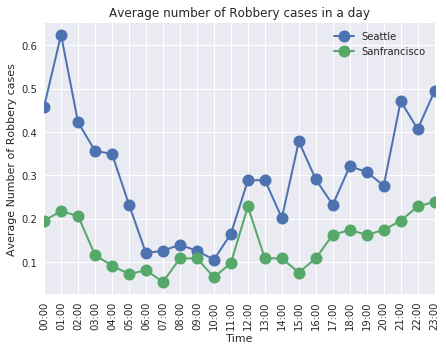

In [57]:
fig,ax=plt.subplots(figsize=(7, 5))
%store -r rob #Robbery data from the San Francisco dataset
dfhourly['ROBBERY'].plot(ax=ax,marker='o',ms=12,title='Crimes',lw=2,label='Seattle')
rob.plot(ax=ax,marker='o',ms=12,title='Crimes',lw=2,label='Sanfrancisco')
ax.set_ylabel('Average Number of Robbery cases')
ax.set_title('Average number of Robbery cases in a day')
ax.set_xticks(np.arange(24))
timex=np.array([datetime.datetime.strptime(str(i),'%H').strftime('%H:%M') for i in range(24)])
ax.set_xticklabels(timex)
plt.setp(plt.xticks()[1], rotation=90)
ax.set_xlabel('Time')
plt.legend(loc=0);
plt.savefig('seattlesanrobbery.png', bbox_inches='tight')

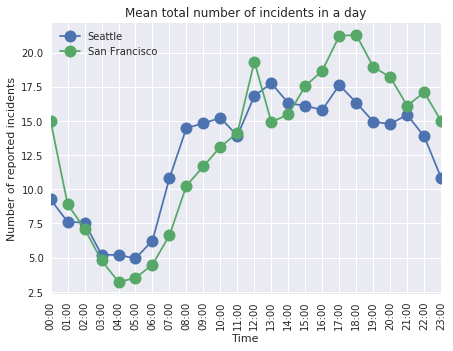

In [51]:
%store -r sanallcrimes
fig,ax=plt.subplots(figsize=(7,5))
allcrimes.plot(ax=ax,marker='o',ms=12,label='Seattle') 
sanallcrimes.plot(ax=ax,marker='o',ms=12,label='San Francisco')
ax.set_xticks(np.arange(24))
ax.set_xticklabels(timex)
plt.setp(plt.xticks()[1], rotation=90)
ax.set_xlabel('Time')
ax.set_ylabel('Number of reported incidents')
ax.set_title('Mean total number of incidents in a day')
plt.legend(loc='best')
plt.savefig('seattlesantotal.png', bbox_inches='tight')

In [52]:
dfsessions=dfhourly.copy()
dfind=dfhourly.sum().sort_values()[0:25].index
dfsessions.drop(dfind,axis=1,inplace=True)

In [53]:
parts=[]
for i in range(24):
    if i<6: parts.append('Early Morning')
    elif i<12 and i>5:parts.append('Morning')
    elif i>11 and i<18:parts.append('Afternoon')    
    else: parts.append('Evening')
dfsessions['PartsOfDay']=pd.Series(parts)
dfsessions=dfsessions.reset_index()
dfsessions=dfsessions.set_index(['PartsOfDay','hour'])

dfearly=dfsessions[dfsessions.index.droplevel(1)=='Early Morning']
dfmorning=dfsessions[dfsessions.index.droplevel(1)=='Morning']
dfnoon=dfsessions[dfsessions.index.droplevel(1)=='Afternoon']
dfevening=dfsessions[dfsessions.index.droplevel(1)=='Evening']

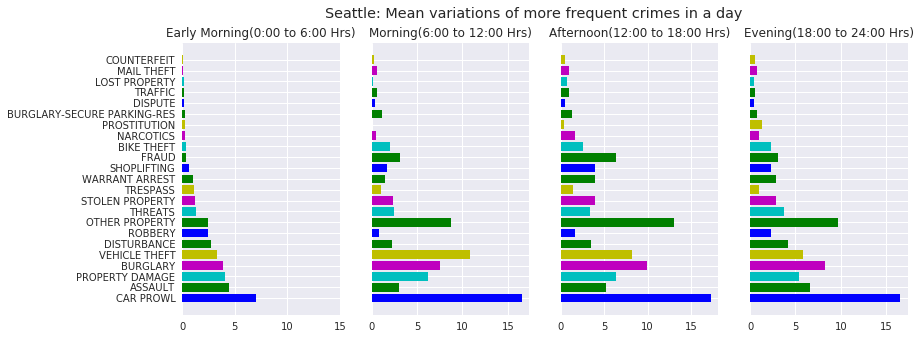

In [54]:
fig,ax=plt.subplots(1,4,figsize=(13, 5),sharey=True)
df0=dfearly.sum().sort_values(ascending=False)
d=df0
xx=ax[0]
xx.barh(np.arange(len(d)), df0, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,5,10,15]))
xx.set_yticklabels(df0.index)    
xx.set_title(dfearly.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfearly.index.droplevel(0)[0],y=dfearly.index.droplevel(0)[5]+1))

df1=dfmorning.sum().sort_values(ascending=False).reindex(df0.index)
xx=ax[1]
xx.barh(np.arange(len(d)), df1, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,5,10,15]))
# xx.set_yticklabels(d.index)    
xx.set_title(dfmorning.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfmorning.index.droplevel(0)[0],y=dfmorning.index.droplevel(0)[5]+1))
# xx.invert_xaxis()
# xx.yaxis.tick_right()

df2=dfnoon.sum().reindex(df0.index)
xx=ax[2]
xx.barh(np.arange(len(d)), df2, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,5,10,15]))
# xx.set_yticklabels(d.index)    
xx.set_title(dfnoon.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfnoon.index.droplevel(0)[0],y=dfnoon.index.droplevel(0)[5]+1))
# xx.invert_xaxis()
# xx.yaxis.tick_right()

df3=dfevening.sum().reindex(df0.index)
xx=ax[3]
xx.barh(np.arange(len(d)), df3, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,5,10,15]))
# xx.set_yticklabels(d.index)    
xx.set_title(dfevening.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfevening.index.droplevel(0)[0],y=dfevening.index.droplevel(0)[5]+1))
fig.suptitle('Seattle: Mean variations of more frequent crimes in a day')  
plt.savefig('seattlefreqcrimes.png', bbox_inches='tight')

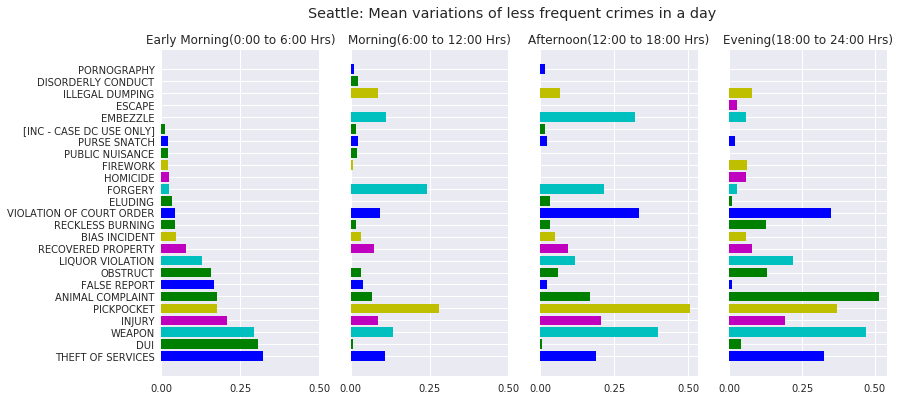

In [55]:
dfsessions=dfhourly.copy()
dfind=dfhourly.sum().sort_values()[25:len(dfhourly.sum())].index
dfsessions.drop(dfind,axis=1,inplace=True)
parts=[]
for i in range(24):
    if i<6: parts.append('Early Morning')
    elif i<12 and i>5:parts.append('Morning')
    elif i>11 and i<18:parts.append('Afternoon')    
    else: parts.append('Evening')
dfsessions['PartsOfDay']=pd.Series(parts)
dfsessions=dfsessions.reset_index()
dfsessions=dfsessions.set_index(['PartsOfDay','hour'])

dfearly=dfsessions[dfsessions.index.droplevel(1)=='Early Morning']
dfmorning=dfsessions[dfsessions.index.droplevel(1)=='Morning']
dfnoon=dfsessions[dfsessions.index.droplevel(1)=='Afternoon']
dfevening=dfsessions[dfsessions.index.droplevel(1)=='Evening']



fig,ax=plt.subplots(1,4,figsize=(13, 6),sharey=True)
df0=dfearly.sum().sort_values(ascending=False)
d=df0
xx=ax[0]
xx.barh(np.arange(len(d)), df0, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,0.25,0.5]))
xx.set_yticklabels(df0.index)    
xx.set_title(dfearly.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfearly.index.droplevel(0)[0],y=dfearly.index.droplevel(0)[5]+1))

df1=dfmorning.sum().sort_values(ascending=False).reindex(df0.index)
xx=ax[1]
xx.barh(np.arange(len(d)), df1, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,0.25,0.5]))
# xx.set_yticklabels(d.index)    
xx.set_title(dfmorning.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfmorning.index.droplevel(0)[0],y=dfmorning.index.droplevel(0)[5]+1))
# xx.invert_xaxis()
# xx.yaxis.tick_right()

df2=dfnoon.sum().reindex(df0.index)
xx=ax[2]
xx.barh(np.arange(len(d)), df2, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,0.25,0.5]))
# xx.set_yticklabels(d.index)    
xx.set_title(dfnoon.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfnoon.index.droplevel(0)[0],y=dfnoon.index.droplevel(0)[5]+1))
# xx.invert_xaxis()
# xx.yaxis.tick_right()

df3=dfevening.sum().reindex(df0.index)
xx=ax[3]
xx.barh(np.arange(len(d)), df3, align='center',color=['b', 'g', 'c', 'm', 'y', 'g'])
xx.set_yticks(np.arange(len(d)))
xx.set_xticks(np.array([0,0.25,0.5]))
# xx.set_yticklabels(d.index)    
xx.set_title(dfevening.index.droplevel(1)[0] + '({x}:00 to {y}:00 Hrs)'.format(x=dfevening.index.droplevel(0)[0],y=dfevening.index.droplevel(0)[5]+1))
fig.suptitle('Seattle: Mean variations of less frequent crimes in a day')  
plt.savefig('seattlelesscrimes.png', bbox_inches='tight')